In [2]:
from numpy import ndarray, log
from pandas import read_csv, DataFrame, Series
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap

from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.pyplot import figure, savefig, show, subplots

from dslab_functions import plot_multiline_chart, plot_multi_scatters_chart, plot_bar_chart, plot_multibar_chart, set_chart_labels, get_variable_types, define_grid, HEIGHT

# read file
filename = "class_credit_score.csv"
file_tag = "class_credit_score"
df : DataFrame = read_csv('class_credit_score.csv')

#df

## Data Dimensionality

In [ ]:
figure(figsize=(4, 2))

values: dict[str, int] = {"nr records": df.shape[0], "nr variables": df.shape[1]}

plot_bar_chart(list(values.keys()), list(values.values()), title="Nr of records vs nr of variables")
savefig(f"images/{file_tag}_records_variables.png")
show()

In [ ]:
# description
df.describe(include="all")

### SHAPE

In [ ]:
# shape (Nr records x Nr variables)

print("Nr of records: ", len(df))
print("Dimensionality: ", df.shape)

### VARIABLE TYPES

In [ ]:
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)
counts: dict[str, int] = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])

figure(figsize=(4, 2))
plot_bar_chart(
    list(counts.keys()), list(counts.values()), title="Nr of variables per type"
)
savefig(f"images/{file_tag}_variable_types.png")
show()

In [ ]:
symbolic: list[str] = variable_types["symbolic"]
df[symbolic] = df[symbolic].apply(lambda x: x.astype("category"))
df.dtypes

### MISSING VALUES

In [ ]:
mv: dict[str, int] = {}
for var in df.columns:
    nr: int = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr

figure()
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
savefig(f"images/{file_tag}_mv.png")
show()

## Data Granularity

In [ ]:
#data granularity -> symbolic variables

## Data Distribution

In [ ]:
# global boxplot
variables_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variables_types["numeric"]
if [] != numeric:
    df[numeric].boxplot(rot=45)
    savefig(f"images/{file_tag}_global_boxplot.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
# boxplots for individual numeric vars
if [] != numeric:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric))
    fig: Figure
    axs: ndarray
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(numeric)):
        axs[i, j].set_title("Boxplot for %s" % numeric[n])
        axs[i, j].boxplot(df[numeric[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
# outliers
NR_STDEV: int = 2
IQR_FACTOR: float = 1.5

def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom

def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}


if [] != numeric:
    outliers: dict[str, int] = count_outliers(df, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
# histograms for numeric
if [] != numeric:
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i: int
    j: int
    i, j = 0, 0
    for n in range(len(numeric)):
        set_chart_labels(
            axs[i, j],
            title=f"Histogram for {numeric[n]}",
            xlabel=numeric[n],
            ylabel="nr records",
        )
        axs[i, j].hist(df[numeric[n]].dropna().values, "auto")
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_histograms_numeric.png")
    show()
else:
    print("There are no numeric variables.")

In [ ]:
# distributions for numeric

In [1]:
#histograms for symbolic
variables_types: dict[str, list] = get_variable_types(df)
symbolic: list[str] = variables_types["symbolic"] + variables_types["binary"]
if [] != symbolic:
    rows, cols = define_grid(len(symbolic))
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    i, j = 0, 0
    for n in range(len(symbolic)):
        counts: Series = df[symbolic[n]].value_counts()
        plot_bar_chart(
            counts.index.to_list(),
            counts.to_list(),
            ax=axs[i, j],
            title="Histogram for %s" % symbolic[n],
            xlabel=symbolic[n],
            ylabel="nr records",
            percentage=False,
        )
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_histograms_symbolic.png")
    show()
else:
    print("There are no symbolic variables.")

NameError: name 'get_variable_types' is not defined

In [ ]:
# class distribution

## Data Sparsity 

In [ ]:
# scatter-plots (all x all - including class)

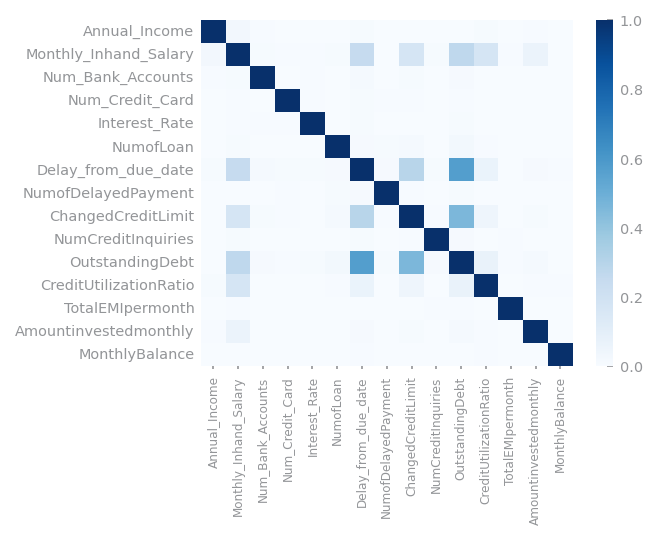

In [3]:
# correlation (all x all - including class)
variables_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = df[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
savefig(f"images/{file_tag}_correlation_analysis.png")
show()